In [1]:
import torch
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt

# Add the parent directory of the script (i.e., project/) to sys.path
import sys
sys.path.append('../utils')
from Architectures import FNN
from DataGenerators import LotkaVolterra, sample_with_noise
from UPINN import UPINN
from Utils import SoftAdapt, cv_sindy

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

### Generate Data from System

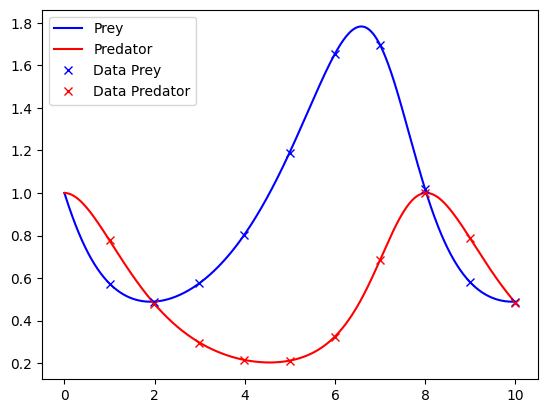

In [2]:
# Generate some data
alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
x0, y0 = 1.0, 1.0

time_int = [0, 10]
N = 1000

LV_generator = LotkaVolterra(alpha, beta, gamma, delta, torch.tensor([x0, y0], dtype=torch.float32))
t = torch.linspace(time_int[0], time_int[1], N).reshape(-1, 1)
X = LV_generator.solve(t)

# Sample subset and add noise
t_d, X_d = sample_with_noise(10, t, X, epsilon=0.0)

# Plot data
plt.plot(t, X[:, 0], color='b', label='Prey')
plt.plot(t, X[:, 1], color='r', label='Predator')
plt.plot(t_d, X_d[:, 0], 'bx', label='Data Prey')
plt.plot(t_d, X_d[:, 1], 'rx', label='Data Predator')
plt.legend()
plt.show()

### Setup Boundary Value Problem

Assume that $-\beta x y$ and $\gamma x y$ is not known, and we want to learn them from data.

In [3]:
# Initial condition
t0 = torch.tensor([[0.0]])
X0 = torch.tensor([[x0, y0]])

In [4]:
# Collocation points
N_c = 1000
t_c = torch.linspace(time_int[0], time_int[1], N_c).reshape(-1, 1)

In [5]:
class LV(torch.nn.Module):
    def __init__(self, alpha, beta, gamma, delta):
        super(LV, self).__init__()
        self.alpha, self.beta, self.gamma, self.delta = alpha, beta, gamma, delta
    
    def forward(self, t, U):
        U = torch.tensor(U) if type(U) is not torch.Tensor else U
        x, y = U[:, 0:1], U[:, 1:2]
        dxdt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        dydt = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]

        pde_x = dxdt - (self.alpha * x - self.beta * x * y)
        pde_y = dydt - (- self.delta * y + self.gamma * x * y)
        return torch.hstack([pde_x, pde_y])

In [6]:
class Sparse_LV(torch.nn.Module):
    def __init__(self, alpha, delta):
        super(Sparse_LV, self).__init__()
        self.alpha, self.delta = alpha, delta
    
    def forward(self, t, U):
        U = torch.tensor(U) if type(U) is not torch.Tensor else U
        x, y = U[:, 0:1], U[:, 1:2]
        dxdt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        dydt = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]

        pde_x = dxdt - (self.alpha * x)
        pde_y = dydt - (- self.delta * y)
        return torch.hstack([pde_x, pde_y])

### Initiaize and train UPINN

In [7]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.ReLU(),
)
G = FNN(
    dims=[3, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

# F = LV(2/3, torch.nn.Parameter(torch.tensor(0.5)), 1.0, 1.0) 
F = Sparse_LV(2/3, 1.0)

# Instantiate the UPINN
upinn = UPINN(u, F, G, data_points=(t_d, X_d), initial_points=(t0, X0), collocation_points=t_c)

In [8]:
# Train the UPINN
upinn.train_loop(epochs=10000, optimizer=torch.optim.AdamW, optimizer_args=dict(lr=3e-3, weight_decay=1e-10))

Beginning training...
Running on: cpu


100%|██████████| 10000/10000 [02:32<00:00, 65.74it/s, loss=9.61e-06, init_loss=3.38e-07, bc_loss=0.00e+00, data_loss=1.69e-06, pde_loss=7.58e-06]

Training complete.
Moving model to CPU...


### Evaluate

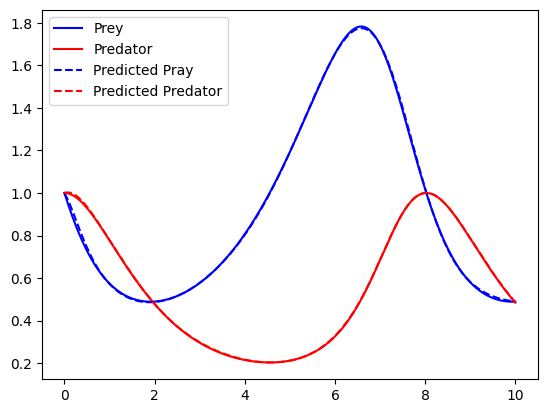

In [9]:
# Plot the results
import matplotlib.pyplot as plt
X_pred = upinn.predict(t).detach().numpy()

plt.plot(t, X[:, 0], 'b', label='Prey')
plt.plot(t, X[:, 1], 'r', label='Predator')
plt.plot(t, X_pred[:, 0], 'b--', label='Predicted Pray')
plt.plot(t, X_pred[:, 1], 'r--', label='Predicted Predator')
plt.legend()
plt.show()

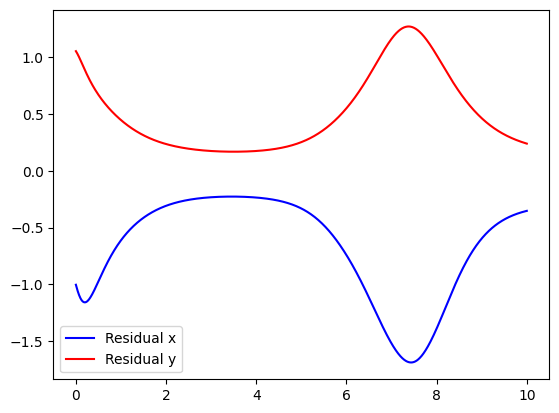

In [10]:
# Plot the residuals
res = upinn.G(torch.cat([t, upinn.u(t)], dim=1)).detach().numpy()
plt.plot(t, res[:, 0], 'b', label='Residual x')
plt.plot(t, res[:, 1], 'r', label='Residual y')
plt.legend()
plt.show()

### Use SINDy to extract the equations

In [11]:
# Generate data from the solution network
t = np.linspace(0, 10, 1000).reshape(-1, 1)
X = upinn.u(torch.tensor(t, dtype=torch.float32)).detach().numpy()
X_dot = upinn.G(torch.cat([torch.tensor(t, dtype=torch.float32), upinn.u(torch.tensor(t, dtype=torch.float32))], dim=1)).detach().numpy()

# Split data into training and test set
train_test_split = 0.8
train_idx = np.arange(0, int(train_test_split*len(t)))
test_idx = np.arange(int(train_test_split*len(t)), len(t))

In [12]:
best_model, _ = cv_sindy(X, t, X_dot, feature_names=['x', 'y'], degree=2)
best_model.print()

(x)' = -1.329 x y
(y)' = 1.000 x y
